In [1]:
import os
import numpy as np
import pandas as pd
from hpfrec import HPF
import heapq
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
randseed = 42
print("random seed: ", randseed)
np.random.seed(randseed)

# dir_r3 = 'C:/Users/Sten Stokroos/Desktop/NEW/zelf/Data/out/'
dir_ml = 'C:/Users/Sten Stokroos/Desktop/NEW/zelf/Data/out/'

def choose_data(dat, test_size):
    if dat == 'ml2':
        train = pd.read_csv(os.path.join(dir_ml, 'ml_train2.csv'), sep="\t", header=None, names=['userId', 'songId', 'rating'], usecols=[0, 1, 2], engine="python")
        test = pd.read_csv(os.path.join(dir_ml, 'ml_test2.csv'), sep="\t", header=None, names=['userId', 'songId', 'rating'], usecols=[0, 1, 2], engine="python")
        val = None  # Assuming no validation set for 'ml2'

        user_ids = train['userId'].unique()
        item_ids = train['songId'].unique()

        n_users = len(user_ids)
        n_items = len(item_ids)
    elif dat == 'ml':
        ml_full = pd.read_csv(os.path.join(dir_ml, 'ml-1m_full.csv'), sep="\t", header=None, names=['userId', 'songId', 'rating'], usecols=[0, 1, 2], engine="python")

        # Get unique user IDs

        user_ids = ml_full['userId'].unique()
        item_ids = ml_full['songId'].unique()

        n_users = len(user_ids)
        n_items = len(item_ids)
        # Split user IDs for train, validation, and test sets
        train, test = train_test_split(ml_full, test_size=test_size, random_state=42)
        # train, val = train_test_split(train, test_size=val_size/(1-test_size), random_state=42)

    else:
        print('Wrong data input')
        return None, None, None

    # Print the sizes of the datasets
    print(f"Train set size: {train.shape[0]} ratings")
    # print(f"Validation set size: {val.shape[0] if val is not None else 0} ratings")
    print(f"Test set size: {test.shape[0]} ratings")
    # print(ml_full.shape[0])
    # print(train.shape[0] + val.shape[0] +  test.shape[0])

    return train, test, n_users, n_items

ml = 'ml2'

train_df, test_df, users, items = choose_data(ml, test_size= 0.1)

# Rename columns to 'UserId', 'ItemId', 'Count'
train_df = train_df.rename(columns={'userId': 'UserId', 'songId': 'ItemId', 'rating': 'Count'})
# val_df = val_df.rename(columns={'userId': 'UserId', 'songId': 'ItemId', 'rating': 'Count'})

test_df = test_df.rename(columns={'userId': 'UserId', 'songId': 'ItemId', 'rating': 'Count'})

# Convert ratings to binary exposure data (1 if Count > 0, else 0)
train_df['Count'] = (train_df['Count'] > 0).astype(int)
# val_df['Count'] = (val_df['Count'] > 0).astype(int)
test_df['Count'] = (test_df['Count'] > 0).astype(int)

# Get unique user and item IDs
all_observed_df = pd.concat([train_df, test_df])
user_ids = all_observed_df['UserId'].unique()
item_ids = all_observed_df['ItemId'].unique()
num_users = len(user_ids)
num_items = len(item_ids)

print(num_items)
print(num_users)

def load_negative_file(filename):
    negativeList = []
    with open(filename, "r") as f:
        line = f.readline()
        while line != None and line != "":
            arr = line.split("\t")
            negatives = []
            for x in arr[1:]:
                negatives.append(int(x))
            negativeList.append(negatives)
            line = f.readline()
    return negativeList

negative_samples_file = 'C:/Users/Sten Stokroos/Desktop/NEW/zelf/Data/out/ml2_negatives.csv'
test_negatives = load_negative_file(negative_samples_file)

# Define evaluation functions
def getNDCG(ranklist, gtItem):
    for i in range(len(ranklist)):
        item = ranklist[i]
        if item == gtItem:
            return math.log(2) / math.log(i + 2)
    return 0

def eval_one_rating(idx, model, test_ratings, test_negatives, topk):
    rating = test_ratings[idx]
    user = rating[0]
    gtItem = rating[1]
    items = test_negatives[idx]
    items.append(gtItem)
    
    # Get prediction scores
    map_item_score = {}
    users = np.full(len(items), user, dtype='int32')
    predictions = model.predict(user=users, item=np.array(items))
    
    for i in range(len(items)):
        item = items[i]
        map_item_score[item] = predictions[i]
    items.pop()
    
    # Evaluate top rank list
    ranklist = heapq.nlargest(topk, map_item_score, key=map_item_score.get)
    ndcg = getNDCG(ranklist, gtItem)
    return ndcg

k_values = [5]
performance = []
log_likelihoods = []

# Prepare test ratings
test_ratings = test_df[['UserId', 'ItemId']].values.tolist()

for k in k_values:
    print(f"Training HPF model with k={k}...")
    recommender = HPF(
        k=k, a=0.3, a_prime=0.3, b_prime=1.0,
        c=0.3, c_prime=0.3, d_prime=1.0, ncores=-1,
        stop_crit='train-llk', check_every=10, stop_thr=1e-3,
        users_per_batch=None, items_per_batch=None, step_size=lambda x: 1/np.sqrt(x+2),
        maxiter=100, use_float=True, reindex=False, verbose=True,
        random_seed=None, allow_inconsistent_math=False, full_llk=False,
        alloc_full_phi=False, keep_data=True, save_folder=None,
        produce_dicts=True, keep_all_objs=True, sum_exp_trick=False
    )

    # Fit the model to the training data
    recommender.fit(train_df, test_df)
    topk = 10

    # Calculate log-likelihood on the validation set
    llk = recommender.eval_llk(test_df)
    log_likelihoods.append(llk['llk'])
    print(f"Log-likelihood for k={k}: {llk['llk']}")

    # Evaluate the model using NDCG
    ndcg_scores = [eval_one_rating(i, recommender, test_ratings, test_negatives, topk) for i in tqdm(range(len(test_ratings)))]
    avg_ndcg = np.mean(ndcg_scores)
    performance.append(avg_ndcg)
    print(f"Average NDCG for k={k}: {avg_ndcg}")

    # Initialize an empty matrix for exposures
    exposure_matrix = np.zeros((len(user_ids), len(item_ids)))

    # Predict the exposure data for all user-item pairs
    for i, user in enumerate(user_ids):
        exposures = recommender.predict(user=[user] * len(item_ids), item=item_ids)
        exposure_matrix[i, :] = exposures

    # Convert the exposure matrix to a DataFrame
    exposure_df = pd.DataFrame(exposure_matrix, index=user_ids, columns=item_ids)

    # Save the exposure matrix to a CSV file with k in the file name
    output_file = f'C:/Users/Sten Stokroos/Desktop/NEW/zelf/Data/exposure_output/ml2_exp_k_{k}.csv'
    exposure_df.to_csv(output_file, index=False, header=False)







random seed:  42
Train set size: 994173 ratings
Test set size: 6040 ratings
3706
6040
Training HPF model with k=5...
**********************************
Hierarchical Poisson Factorization
**********************************

Number of users: 6040
Number of items: 3706
Latent factors to use: 5

Initializing parameters...
Allocating Phi matrix...
Initializing optimization procedure...
Iteration 10 | train llk: -2882595 | train rmse: 0.7956
Iteration 20 | train llk: -2715831 | train rmse: 0.7705
Iteration 30 | train llk: -2617688 | train rmse: 0.7503
Iteration 40 | train llk: -2610073 | train rmse: 0.7499
Iteration 50 | train llk: -2608067 | train rmse: 0.7502


Optimization finished
Final log-likelihood: -2608067
Final RMSE: 0.7502
Minutes taken (optimization part): 0.1

Log-likelihood for k=5: -17509.10830345899


100%|██████████| 6040/6040 [00:02<00:00, 2937.79it/s]


Average NDCG for k=5: 0.3104166622836881


Unique values in train_df['Count']: [1]
Unique values in test_df['Count']: [1]
**********************************
Hierarchical Poisson Factorization
**********************************

Number of users: 6040
Number of items: 3706
Latent factors to use: 30

Initializing parameters...
Allocating Phi matrix...
Initializing optimization procedure...
Iteration 10 | train llk: -2707274 | train rmse: 0.8098
Iteration 20 | train llk: -2407974 | train rmse: 0.7554
Iteration 30 | train llk: -2249619 | train rmse: 0.7147
Iteration 40 | train llk: -2224931 | train rmse: 0.7084
Iteration 50 | train llk: -2216762 | train rmse: 0.7063
Iteration 60 | train llk: -2212858 | train rmse: 0.7054
Iteration 70 | train llk: -2210636 | train rmse: 0.7048
Iteration 80 | train llk: -2209131 | train rmse: 0.7044
Iteration 90 | train llk: -2208094 | train rmse: 0.7041
Iteration 100 | train llk: -2207281 | train rmse: 0.7038


Optimization finished
Final log-likelihood: -2207281
Final RMSE: 0.7038
Minutes taken (opt

In [5]:
results_df = pd.DataFrame({
    'k': k_values,
    'log_likelihood': log_likelihoods,
    'average_ndcg': performance
})

# Save the DataFrame to a CSV file
output_file = 'C:/Users/Sten Stokroos/Desktop/NEW/zelf/Data/exposure_output/r3_results.csv'
results_df.to_csv(output_file, index=False)

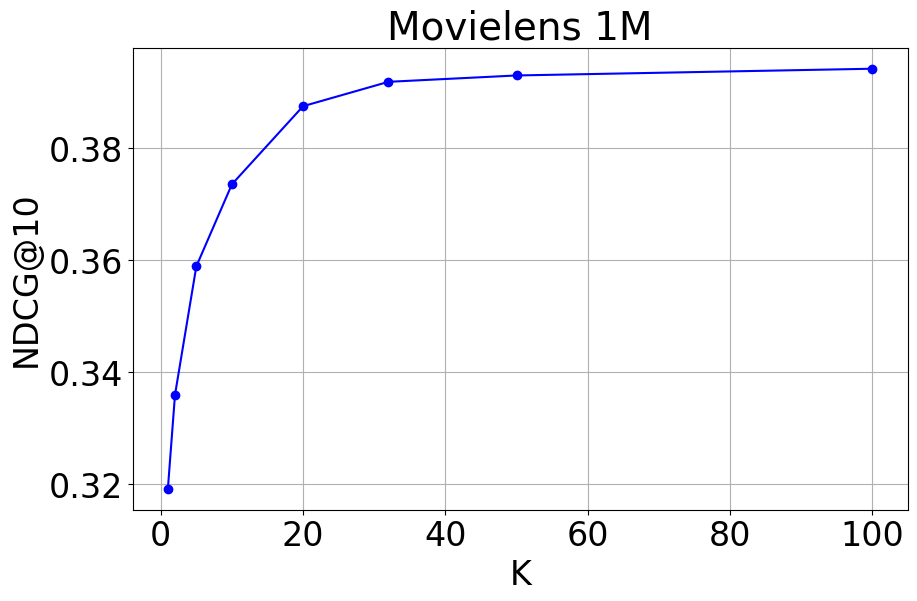

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_with_fewer_yticks(df, y_col, title, ylabel, color, save=False, filename=None):
    plt.figure(figsize=(10, 6))
    plt.plot(df['k'], df[y_col], marker='o', linestyle='-', color=color)
    plt.title(title, fontsize=font_size + 4)
    plt.xlabel('K', fontsize=font_size)
    plt.ylabel(ylabel, fontsize=font_size)
    plt.xticks(fontsize=font_size)
    plt.yticks(fontsize=font_size)
    plt.gca().yaxis.set_major_locator(plt.MaxNLocator(5))  # Limit the number of y-ticks to 5
    # plt.gca().ticklabel_format(style='sci', axis='y', scilimits=(3,2))  # Set scientific notation for y-axis
    plt.grid(True)
    
    if save and filename:
        plt.savefig(filename, bbox_inches='tight')
    
    plt.show()

# Load the CSV data into a DataFrame
results_df = pd.read_csv('C:/Users/Sten Stokroos/Desktop/NEW/zelf/Data/exposure_output/r3_results.csv')


# Define font size
font_size = 24

# Plotting Average NDCG vs Latent Factors K with fewer y-ticks
plot_with_fewer_yticks(results_df, 'average_ndcg', 'Movielens 1M', 'NDCG@10', 'b', save=True, filename='C:/Users/Sten Stokroos/Desktop/NEW/zelf/Data/plots/Exposure_model/ncdg_ml_01.png')

# Plotting Log Likelihood vs Latent Factors K with fewer y-ticks
# plot_with_fewer_yticks(results_df, 'log_likelihood', 'Movielens 1M', 'Log Likelihood (x 1e5)', 'r', save=True, filename='C:/Users/Sten Stokroos/Desktop/NEW/zelf/Data/plots/Exposure_model/loglike_ml_01.png')


random seed:  42
Training HPF model with k=10...
**********************************
Hierarchical Poisson Factorization
**********************************

Number of users: 6040
Number of items: 3706
Latent factors to use: 10

Initializing parameters...
Allocating Phi matrix...
Initializing optimization procedure...


c:\Users\Public\ana\Lib\site-packages\hpfrec\__init__.py:469: UserWarning: 'counts_df' contains observations with a count value less than 1, these will be ignored. Any user or item associated exclusively with zero-value observations will be excluded. If using 'reindex=False', make sure that your data still meets the necessary criteria. If you still want to use these observations, set 'stop_crit' to 'diff-norm' or 'maxiter'.
  warnings.warn(
c:\Users\Public\ana\Lib\site-packages\hpfrec\__init__.py:510: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.input_df['Count'] = self.input_df["Count"].astype(cython_loops.c_real_t)


Iteration 10 | train llk: -2160421 | train rmse: 0.8501
Iteration 20 | train llk: -2008634 | train rmse: 0.8243
Iteration 30 | train llk: -1921993 | train rmse: 0.8006
Iteration 40 | train llk: -1912311 | train rmse: 0.7980
Iteration 50 | train llk: -1909229 | train rmse: 0.7973
Iteration 60 | train llk: -1907716 | train rmse: 0.7968


Optimization finished
Final log-likelihood: -1907716
Final RMSE: 0.7968
Minutes taken (optimization part): 0.1

Log-likelihood for k=10: -201872.71977299688


100%|██████████| 100022/100022 [00:32<00:00, 3032.17it/s]
c:\Users\Public\ana\Lib\site-packages\hpfrec\__init__.py:555: UserWarning: 'val_set' contains observations with a count value less than 1, these will be ignored.
  warnings.warn(


Average NDCG for k=10: 0.42816141178768896
Observed Log-Likelihood for k=10: -362666.17808815325
Replicated Log-Likelihood 1/50 for k=10: -18595.639770861897
Replicated Log-Likelihood 2/50 for k=10: -18595.639770861897
Replicated Log-Likelihood 3/50 for k=10: -18595.639770861897


c:\Users\Public\ana\Lib\site-packages\hpfrec\__init__.py:555: UserWarning: 'val_set' contains observations with a count value less than 1, these will be ignored.
  warnings.warn(
c:\Users\Public\ana\Lib\site-packages\hpfrec\__init__.py:555: UserWarning: 'val_set' contains observations with a count value less than 1, these will be ignored.
  warnings.warn(
c:\Users\Public\ana\Lib\site-packages\hpfrec\__init__.py:555: UserWarning: 'val_set' contains observations with a count value less than 1, these will be ignored.
  warnings.warn(
c:\Users\Public\ana\Lib\site-packages\hpfrec\__init__.py:555: UserWarning: 'val_set' contains observations with a count value less than 1, these will be ignored.
  warnings.warn(
c:\Users\Public\ana\Lib\site-packages\hpfrec\__init__.py:555: UserWarning: 'val_set' contains observations with a count value less than 1, these will be ignored.
  warnings.warn(
c:\Users\Public\ana\Lib\site-packages\hpfrec\__init__.py:555: UserWarning: 'val_set' contains observation

Replicated Log-Likelihood 4/50 for k=10: -18595.639770861897
Replicated Log-Likelihood 5/50 for k=10: -18595.639770861897
Replicated Log-Likelihood 6/50 for k=10: -18595.639770861897
Replicated Log-Likelihood 7/50 for k=10: -18595.639770861897
Replicated Log-Likelihood 8/50 for k=10: -18595.639770861897
Replicated Log-Likelihood 9/50 for k=10: -18595.639770861897
Replicated Log-Likelihood 10/50 for k=10: -18595.639770861897
Replicated Log-Likelihood 11/50 for k=10: -18595.639770861897
Replicated Log-Likelihood 12/50 for k=10: -18595.639770861897
Replicated Log-Likelihood 13/50 for k=10: -18595.639770861897
Replicated Log-Likelihood 14/50 for k=10: -18595.639770861897
Replicated Log-Likelihood 15/50 for k=10: -18595.639770861897
Replicated Log-Likelihood 16/50 for k=10: -18595.639770861897
Replicated Log-Likelihood 17/50 for k=10: -18595.639770861897


c:\Users\Public\ana\Lib\site-packages\hpfrec\__init__.py:555: UserWarning: 'val_set' contains observations with a count value less than 1, these will be ignored.
  warnings.warn(
c:\Users\Public\ana\Lib\site-packages\hpfrec\__init__.py:555: UserWarning: 'val_set' contains observations with a count value less than 1, these will be ignored.
  warnings.warn(
c:\Users\Public\ana\Lib\site-packages\hpfrec\__init__.py:555: UserWarning: 'val_set' contains observations with a count value less than 1, these will be ignored.
  warnings.warn(
c:\Users\Public\ana\Lib\site-packages\hpfrec\__init__.py:555: UserWarning: 'val_set' contains observations with a count value less than 1, these will be ignored.
  warnings.warn(
c:\Users\Public\ana\Lib\site-packages\hpfrec\__init__.py:555: UserWarning: 'val_set' contains observations with a count value less than 1, these will be ignored.
  warnings.warn(
c:\Users\Public\ana\Lib\site-packages\hpfrec\__init__.py:555: UserWarning: 'val_set' contains observation

Replicated Log-Likelihood 18/50 for k=10: -18595.639770861897
Replicated Log-Likelihood 19/50 for k=10: -18595.639770861897
Replicated Log-Likelihood 20/50 for k=10: -18595.639770861897
Replicated Log-Likelihood 21/50 for k=10: -18595.639770861897
Replicated Log-Likelihood 22/50 for k=10: -18595.639770861897
Replicated Log-Likelihood 23/50 for k=10: -18595.639770861897
Replicated Log-Likelihood 24/50 for k=10: -18595.639770861897
Replicated Log-Likelihood 25/50 for k=10: -18595.639770861897
Replicated Log-Likelihood 26/50 for k=10: -18595.639770861897
Replicated Log-Likelihood 27/50 for k=10: -18595.639770861897
Replicated Log-Likelihood 28/50 for k=10: -18595.639770861897
Replicated Log-Likelihood 29/50 for k=10: -18595.639770861897
Replicated Log-Likelihood 30/50 for k=10: -18595.639770861897
Replicated Log-Likelihood 31/50 for k=10: -18595.639770861897
Replicated Log-Likelihood 32/50 for k=10: -18595.639770861897


c:\Users\Public\ana\Lib\site-packages\hpfrec\__init__.py:555: UserWarning: 'val_set' contains observations with a count value less than 1, these will be ignored.
  warnings.warn(
c:\Users\Public\ana\Lib\site-packages\hpfrec\__init__.py:555: UserWarning: 'val_set' contains observations with a count value less than 1, these will be ignored.
  warnings.warn(
c:\Users\Public\ana\Lib\site-packages\hpfrec\__init__.py:555: UserWarning: 'val_set' contains observations with a count value less than 1, these will be ignored.
  warnings.warn(
c:\Users\Public\ana\Lib\site-packages\hpfrec\__init__.py:555: UserWarning: 'val_set' contains observations with a count value less than 1, these will be ignored.
  warnings.warn(
c:\Users\Public\ana\Lib\site-packages\hpfrec\__init__.py:555: UserWarning: 'val_set' contains observations with a count value less than 1, these will be ignored.
  warnings.warn(
c:\Users\Public\ana\Lib\site-packages\hpfrec\__init__.py:555: UserWarning: 'val_set' contains observation

Replicated Log-Likelihood 33/50 for k=10: -18595.639770861897
Replicated Log-Likelihood 34/50 for k=10: -18595.639770861897
Replicated Log-Likelihood 35/50 for k=10: -18595.639770861897
Replicated Log-Likelihood 36/50 for k=10: -18595.639770861897
Replicated Log-Likelihood 37/50 for k=10: -18595.639770861897
Replicated Log-Likelihood 38/50 for k=10: -18595.639770861897
Replicated Log-Likelihood 39/50 for k=10: -18595.639770861897
Replicated Log-Likelihood 40/50 for k=10: -18595.639770861897
Replicated Log-Likelihood 41/50 for k=10: -18595.639770861897
Replicated Log-Likelihood 42/50 for k=10: -18595.639770861897
Replicated Log-Likelihood 43/50 for k=10: -18595.639770861897
Replicated Log-Likelihood 44/50 for k=10: -18595.639770861897
Replicated Log-Likelihood 45/50 for k=10: -18595.639770861897
Replicated Log-Likelihood 46/50 for k=10: -18595.639770861897


c:\Users\Public\ana\Lib\site-packages\hpfrec\__init__.py:555: UserWarning: 'val_set' contains observations with a count value less than 1, these will be ignored.
  warnings.warn(
c:\Users\Public\ana\Lib\site-packages\hpfrec\__init__.py:555: UserWarning: 'val_set' contains observations with a count value less than 1, these will be ignored.
  warnings.warn(
c:\Users\Public\ana\Lib\site-packages\hpfrec\__init__.py:555: UserWarning: 'val_set' contains observations with a count value less than 1, these will be ignored.
  warnings.warn(
c:\Users\Public\ana\Lib\site-packages\hpfrec\__init__.py:555: UserWarning: 'val_set' contains observations with a count value less than 1, these will be ignored.
  warnings.warn(


Replicated Log-Likelihood 47/50 for k=10: -18595.639770861897
Replicated Log-Likelihood 48/50 for k=10: -18595.639770861897
Replicated Log-Likelihood 49/50 for k=10: -18595.639770861897
Replicated Log-Likelihood 50/50 for k=10: -18595.639770861897
Predictive Score for k=10: 0.0


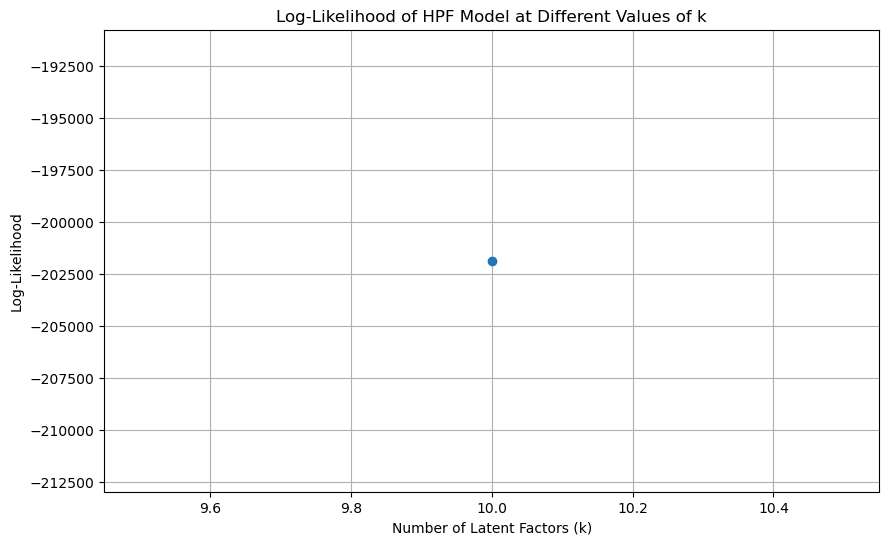

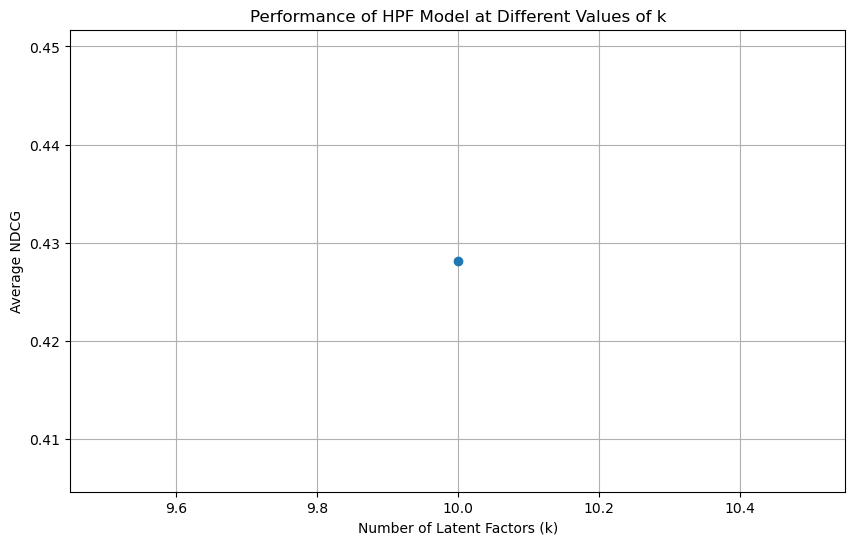

In [2]:
import os
import numpy as np
import pandas as pd
from hpfrec import HPF
import heapq
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from scipy.stats import poisson, norm

# Set random seed for reproducibility
randseed = 42
print("random seed: ", randseed)
np.random.seed(randseed)

dir_r3 = 'C:/Users/Sten Stokroos/Desktop/NEW/zelf/Data/out'
dir_ml = 'C:/Users/Sten Stokroos/Desktop/NEW/zelf/Data/in'

def choose_data(dat):
    # DATA_DIR = 'C:/Users/Sten Stokroos/Desktop/zelf/neural_collaborative_filtering/Data'

    if dat == 'r3':
        train = pd.read_csv(os.path.join(dir_r3, 'r3_train.csv'), sep="\t", header=None, names=['userId', 'songId', 'rating'], usecols=[0, 1, 2], engine="python")
        test = pd.read_csv(os.path.join(dir_r3, 'r3_test.csv'), sep="\t", header=None, names=['userId', 'songId', 'rating'], usecols=[0, 1, 2], engine="python")
    elif dat == 'ml':
        ml_full = pd.read_csv(os.path.join(dir_r3, 'ml-1m_full.csv'), sep="\t", header=None, names=['userId', 'songId', 'rating'], usecols=[0, 1, 2], engine="python")
        train, test = train_test_split(ml_full, test_size = 0.1)
    else:
        print('Wrong data input')

    return train, test

ml = 'ml'
yahoo = 'r3'

train_df, test_df = choose_data(ml)
train_df, vad_df =  train_test_split(train_df, test_size = 0.1) 




# Rename columns to 'UserId', 'ItemId', 'Count'
train_df = train_df.rename(columns={'userId': 'UserId', 'songId': 'ItemId', 'rating': 'Count'})
vad_df = vad_df.rename(columns={'userId': 'UserId', 'songId': 'ItemId', 'rating': 'Count'})
test_df = test_df.rename(columns={'userId': 'UserId', 'songId': 'ItemId', 'rating': 'Count'})

# Convert ratings to binary exposure data (1 if Count > 0, else 0)
train_df['Count'] = (train_df['Count'] > 0).astype(int)
test_df['Count'] = (test_df['Count'] > 0).astype(int)
vad_df['Count'] = (vad_df['Count'] > 0).astype(int)


# Get unique user and item IDs
all_observed_df = pd.concat([train_df, vad_df, test_df])
user_ids = all_observed_df['UserId'].unique()
item_ids = all_observed_df['ItemId'].unique()
num_users = len(user_ids)
num_items = len(item_ids)

# Define the portion of data to hold out
holdout_portion = 0.2
n_holdout = int(holdout_portion * train_df.shape[0])

# Randomly select indices to hold out
holdout_indices = np.random.choice(train_df.index, size=n_holdout, replace=False)
holdout_df = train_df.loc[holdout_indices]
train_df.loc[holdout_indices, 'Count'] = 0  # Mask held out data in training set
# vad_df.loc[holdout_indices, 'Count'] = 0 

# Prepare held-out data
heldout_users = holdout_df['UserId'].values
heldout_items = holdout_df['ItemId'].values
heldout_counts = holdout_df['Count'].values

heldout_eval_df = holdout_df[['UserId', 'ItemId', 'Count']]

def load_negative_file(filename):
    negativeList = []
    with open(filename, "r") as f:
        line = f.readline()
        while line != None and line != "":
            arr = line.split("\t")
            negatives = []
            for x in arr[1:]:
                negatives.append(int(x))
            negativeList.append(negatives)
            line = f.readline()
    return negativeList

negative_samples_file = 'C:/Users/Sten Stokroos/Desktop/NEW/zelf/Data/out/ml_negatives.csv'
test_negatives = load_negative_file(negative_samples_file)

# Define evaluation functions
def getNDCG(ranklist, gtItem):
    for i in range(len(ranklist)):
        item = ranklist[i]
        if item == gtItem:
            return math.log(2) / math.log(i + 2)
    return 0



def eval_one_rating(idx, model, test_ratings, test_negatives, topk):
    rating = test_ratings[idx]
    user = rating[0]
    gtItem = rating[1]
    items = test_negatives[idx]
    items.append(gtItem)
    
    # Get prediction scores
    map_item_score = {}
    users = np.full(len(items), user, dtype='int32')
    predictions = model.predict(user=users, item=np.array(items))
    
    for i in range(len(items)):
        item = items[i]
        map_item_score[item] = predictions[i]
    items.pop()
    
    # Evaluate top rank list
    ranklist = heapq.nlargest(topk, map_item_score, key=map_item_score.get)
    ndcg = getNDCG(ranklist, gtItem)
    return ndcg


k_values = [10]
performance = []
log_likelihoods = []




# Prepare test ratings
test_ratings = test_df[['UserId', 'ItemId']].values.tolist()

for k in k_values:
    print(f"Training HPF model with k={k}...")
    recommender = HPF(
        k=k, a=0.3, a_prime=0.3, b_prime=1.0,
        c=0.3, c_prime=0.3, d_prime=1.0, ncores=-1,
        stop_crit='train-llk', check_every=10, stop_thr=1e-3,
        users_per_batch=None, items_per_batch=None, step_size=lambda x: 1/np.sqrt(x+2),
        maxiter=100, use_float=True, reindex=False, verbose=True,
        random_seed=None, allow_inconsistent_math=False, full_llk=False,
        alloc_full_phi=False, keep_data=True, save_folder=None,
        produce_dicts=True, keep_all_objs=True, sum_exp_trick=False
    )

    # Fit the model to the training data
    recommender.fit(train_df)
    topk = 10

    # Calculate log-likelihood on the validation set
    llk = recommender.eval_llk(vad_df)
    log_likelihoods.append(llk['llk'])
    print(f"Log-likelihood for k={k}: {llk['llk']}")

    # Evaluate the model using NDCG
    ndcg_scores = [eval_one_rating(i, recommender, test_ratings, test_negatives, topk) for i in tqdm(range(len(test_ratings)))]
    avg_ndcg = np.mean(ndcg_scores)
    performance.append(avg_ndcg)
    print(f"Average NDCG for k={k}: {avg_ndcg}")

    # Generate replicated datasets
    n_rep = 50  # Number of replicated datasets to generate
    replicated_heldout_counts = np.zeros((n_rep, len(heldout_users)))

    for i in range(n_rep):
        replicated_counts = recommender.predict(user=heldout_users, item=heldout_items)
        replicated_heldout_counts[i] = replicated_counts

    # Compute expected log likelihood for held-out data and replicated data
    def expected_log_prob(data_df):
        llk_dict = recommender.eval_llk(data_df)
        return llk_dict['llk']

    obs_log_prob = expected_log_prob(heldout_eval_df)
    print(f"Observed Log-Likelihood for k={k}: {obs_log_prob}")

    rep_log_probs = []
    for i in range(n_rep):
        rep_eval_df = pd.DataFrame({
            'UserId': heldout_users,
            'ItemId': heldout_items,
            'Count': replicated_heldout_counts[i] 
        })
        rep_llk = expected_log_prob(rep_eval_df)
        rep_log_probs.append(rep_llk)
        print(f"Replicated Log-Likelihood {i+1}/{n_rep} for k={k}: {rep_llk}")

    # Calculate predictive score
    predictive_score = np.mean([rep_log_prob < obs_log_prob for rep_log_prob in rep_log_probs])
    print(f"Predictive Score for k={k}: {predictive_score}")



# Plot the log-likelihood
plt.figure(figsize=(10, 6))
plt.plot(k_values, log_likelihoods, marker='o')
plt.xlabel('Number of Latent Factors (k)')
plt.ylabel('Log-Likelihood')
plt.title('Log-Likelihood of HPF Model at Different Values of k')
plt.grid(True)
plt.show()

# Plot the performance
plt.figure(figsize=(10, 6))
plt.plot(k_values, performance, marker='o')
plt.xlabel('Number of Latent Factors (k)')
plt.ylabel('Average NDCG')
plt.title('Performance of HPF Model at Different Values of k')
plt.grid(True)
plt.show()





2024-08-05 15:46:20,459 - INFO - Random seed set to: 42
2024-08-05 15:46:26,988 - INFO - Train set size: 900191 ratings
2024-08-05 15:46:26,989 - INFO - Test set size: 100022 ratings
2024-08-05 15:46:27,287 - INFO - Number of users: 6040, Number of items: 3706
2024-08-05 15:46:27,318 - INFO - Training HPF model with k=30...


**********************************
Hierarchical Poisson Factorization
**********************************

Number of users: 6040
Number of items: 3706
Latent factors to use: 30

Initializing parameters...
Allocating Phi matrix...
Initializing optimization procedure...
Iteration 10 | train llk: -2424607 | train rmse: 0.8307
Iteration 20 | train llk: -2159852 | train rmse: 0.7804
Iteration 30 | train llk: -2038209 | train rmse: 0.7473
Iteration 40 | train llk: -2017295 | train rmse: 0.7413
Iteration 50 | train llk: -2009883 | train rmse: 0.7392
Iteration 60 | train llk: -2005716 | train rmse: 0.7381
Iteration 70 | train llk: -2002547 | train rmse: 0.7373
Iteration 80 | train llk: -1999774 | train rmse: 0.7367
Iteration 90 | train llk: -1998113 | train rmse: 0.7363


Optimization finished
Final log-likelihood: -1998113
Final RMSE: 0.7363
Minutes taken (optimization part): 0.7



Predictive Check Progress: 100%|██████████| 135029/135029 [01:17<00:00, 1751.02it/s]
2024-08-05 15:48:26,239 - INFO - Predictive Score for k=30: 0.9603640699405313


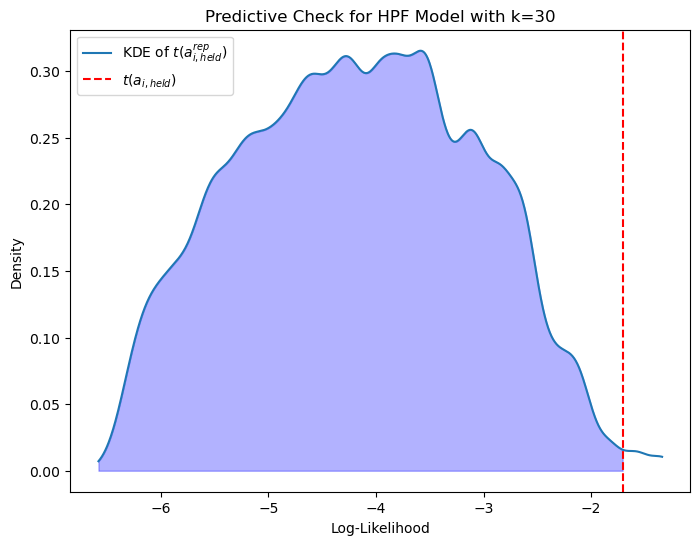

In [12]:
import os
import numpy as np
import pandas as pd
from hpfrec import HPF
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from scipy.stats import gaussian_kde
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Set random seed for reproducibility
randseed = 42
logging.info(f"Random seed set to: {randseed}")
np.random.seed(randseed)

dir_ml = 'C:/Users/Sten Stokroos/Desktop/NEW/zelf/Data/out/'

def choose_data(dat, test_size):
    if dat == 'ml2':
        train = pd.read_csv(os.path.join(dir_ml, 'ml_train2.csv'), sep="\t", header=None, names=['userId', 'songId', 'rating'], usecols=[0, 1, 2], engine="python")
        test = pd.read_csv(os.path.join(dir_ml, 'ml_test2.csv'), sep="\t", header=None, names=['userId', 'songId', 'rating'], usecols=[0, 1, 2], engine="python")
        val = None  # Assuming no validation set for 'ml2'
    elif dat == 'ml':
        ml_full = pd.read_csv(os.path.join(dir_ml, 'ml-1m_full.csv'), sep="\t", header=None, names=['userId', 'songId', 'rating'], usecols=[0, 1, 2], engine="python")

        # Split user IDs for train, validation, and test sets
        train, test = train_test_split(ml_full, test_size=test_size, random_state=42)
    else:
        logging.error('Wrong data input')
        return None, None, None

    # Ensure the columns are renamed properly
    train.columns = ['UserId', 'ItemId', 'Count']
    test.columns = ['UserId', 'ItemId', 'Count']

    user_ids = train['UserId'].unique()
    item_ids = train['ItemId'].unique()
    n_users = len(user_ids)
    n_items = len(item_ids)

    # Data integrity check for user-item pair overlap
    train_pairs = set(zip(train['UserId'], train['ItemId']))
    test_pairs = set(zip(test['UserId'], test['ItemId']))
    overlap = train_pairs.intersection(test_pairs)
    assert len(overlap) == 0, "User-item pair overlap between train and test sets!"

    logging.info(f"Train set size: {train.shape[0]} ratings")
    logging.info(f"Test set size: {test.shape[0]} ratings")

    return train, test, n_users, n_items

ml = 'ml2'

train_df, test_df, users, items = choose_data(ml, test_size=0.1)

# Convert ratings to binary exposure data (1 if Count > 0, else 0)
train_df['Count'] = (train_df['Count'] > 0).astype(int)
test_df['Count'] = (test_df['Count'] > 0).astype(int)

# Get unique user and item IDs
all_observed_df = pd.concat([train_df, test_df])
user_ids = all_observed_df['UserId'].unique()
item_ids = all_observed_df['ItemId'].unique()
num_users = len(user_ids)
num_items = len(item_ids)

logging.info(f"Number of users: {num_users}, Number of items: {num_items}")

k_values = [30]

# Prepare test ratings
test_ratings = test_df[['UserId', 'ItemId']].values.tolist()

for k in k_values:
    logging.info(f"Training HPF model with k={k}...")
    recommender = HPF(
        k=k, a=0.3, a_prime=0.3, b_prime=1.0,
        c=0.3, c_prime=0.3, d_prime=1.0, ncores=-1,
        stop_crit='train-llk', check_every=10, stop_thr=1e-3,
        users_per_batch=None, items_per_batch=None, step_size=lambda x: 1/np.sqrt(x+2),
        maxiter=100, use_float=True, reindex=False, verbose=True,
        random_seed=None, allow_inconsistent_math=False, full_llk=False,
        alloc_full_phi=False, keep_data=True, save_folder=None,
        produce_dicts=True, keep_all_objs=True, sum_exp_trick=False
    )

    # Step 1: Randomly hold out data for predictive checks
    held_out_df = train_df.sample(frac=0.15, random_state=randseed)
    train_subset_df = train_df.drop(held_out_df.index)

    # Data integrity check
    assert train_subset_df.index.isin(held_out_df.index).sum() == 0, "Held-out and training subset overlap!"

    # Step 2: Fit the model to the subset of the training data
    recommender.fit(train_subset_df)

    # Predictive Check
    predictive_scores = []
    actual_log_probs = []
    replicated_log_probs = []
    
    # Add tqdm progress bar here
    for _, row in tqdm(held_out_df.iterrows(), total=held_out_df.shape[0], desc="Predictive Check Progress"):
        user = row['UserId']
        item = row['ItemId']

        # Predict the held-out data for a single user-item pair
        prediction = recommender.predict(user=np.array([user]), item=np.array([item]))

        # Sanity check for prediction
        assert prediction > 0, f"Invalid prediction value: {prediction}"

        # Calculate the log likelihood of the prediction
        actual_log_prob = np.log(prediction)
        actual_log_probs.append(actual_log_prob)

        # Sample from the predictive distribution for all items
        samples = recommender.predict(user=np.full(len(item_ids), user), item=item_ids)
        assert np.all(samples > 0), "Invalid sample prediction values"

        replicated_log_prob = np.log(samples).mean()
        replicated_log_probs.append(replicated_log_prob)

        # Compare the predictive log likelihood
        if replicated_log_prob < actual_log_prob:
            predictive_scores.append(1)
        else:
            predictive_scores.append(0)

    # Calculate the predictive score
    predictive_score = np.mean(predictive_scores)
    logging.info(f"Predictive Score for k={k}: {predictive_score}")

    # Plotting the kernel density estimate (KDE)
    kde = gaussian_kde(replicated_log_probs)
    x_vals = np.linspace(min(replicated_log_probs), max(replicated_log_probs), 1000)
    kde_vals = kde(x_vals)

    plt.figure(figsize=(8, 6))
    plt.plot(x_vals, kde_vals, label='KDE of $t(a^{rep}_{i,held})$')
    plt.axvline(x=np.mean(actual_log_probs), color='r', linestyle='--', label='$t(a_{i,held})$')
    plt.fill_between(x_vals, kde_vals, where=(x_vals <= np.mean(actual_log_probs)), color='blue', alpha=0.3)
    plt.title(f'Predictive Check for HPF Model with k={k}')
    plt.xlabel('Log-Likelihood')
    plt.ylabel('Density')
    plt.legend()
    plt.show()


In [18]:
import os
import numpy as np
import pandas as pd
from hpfrec import HPF
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from scipy.stats import gaussian_kde
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Set random seed for reproducibility
randseed = 42
logging.info(f"Random seed set to: {randseed}")
np.random.seed(randseed)

dir_ml = 'C:/Users/Sten Stokroos/Desktop/NEW/zelf/Data/out/'

def choose_data(dat, test_size):
    if dat == 'ml2':
        train = pd.read_csv(os.path.join(dir_ml, 'ml_train2.csv'), sep="\t", header=None, names=['userId', 'songId', 'rating'], usecols=[0, 1, 2], engine="python")
        test = pd.read_csv(os.path.join(dir_ml, 'ml_test2.csv'), sep="\t", header=None, names=['userId', 'songId', 'rating'], usecols=[0, 1, 2], engine="python")
        val = None  # Assuming no validation set for 'ml2'
    elif dat == 'ml':
        ml_full = pd.read_csv(os.path.join(dir_ml, 'ml-1m_full.csv'), sep="\t", header=None, names=['userId', 'songId', 'rating'], usecols=[0, 1, 2], engine="python")

        # Split user IDs for train, validation, and test sets
        train, test = train_test_split(ml_full, test_size=test_size, random_state=42)
    else:
        logging.error('Wrong data input')
        return None, None, None

    # Ensure the columns are renamed properly
    train.columns = ['UserId', 'ItemId', 'Count']
    test.columns = ['UserId', 'ItemId', 'Count']

    user_ids = train['UserId'].unique()
    item_ids = train['ItemId'].unique()
    n_users = len(user_ids)
    n_items = len(item_ids)

    # Data integrity check for user-item pair overlap
    train_pairs = set(zip(train['UserId'], train['ItemId']))
    test_pairs = set(zip(test['UserId'], test['ItemId']))
    overlap = train_pairs.intersection(test_pairs)
    assert len(overlap) == 0, "User-item pair overlap between train and test sets!"

    logging.info(f"Train set size: {train.shape[0]} ratings")
    logging.info(f"Test set size: {test.shape[0]} ratings")

    return train, test, n_users, n_items

ml = 'ml'

train_df, test_df, users, items = choose_data(ml, test_size=0.1)

# Convert ratings to binary exposure data (1 if Count > 0, else 0)
train_df['Count'] = (train_df['Count'] > 0).astype(int)
test_df['Count'] = (test_df['Count'] > 0).astype(int)

# Get unique user and item IDs
all_observed_df = pd.concat([train_df, test_df])
user_ids = all_observed_df['UserId'].unique()
item_ids = all_observed_df['ItemId'].unique()
num_users = len(user_ids)
num_items = len(item_ids)

logging.info(f"Number of users: {num_users}, Number of items: {num_items}")

k_values = [30]

# Prepare test ratings
test_ratings = test_df[['UserId', 'ItemId']].values.tolist()

for k in k_values:
    logging.info(f"Training HPF model with k={k}...")
    recommender = HPF(
        k=k, a=0.3, a_prime=0.3, b_prime=1.0,
        c=0.3, c_prime=0.3, d_prime=1.0, ncores=-1,
        stop_crit='train-llk', check_every=10, stop_thr=1e-3,
        users_per_batch=None, items_per_batch=None, step_size=lambda x: 1/np.sqrt(x+2),
        maxiter=100, use_float=True, reindex=False, verbose=True,
        random_seed=None, allow_inconsistent_math=False, full_llk=False,
        alloc_full_phi=False, keep_data=True, save_folder=None,
        produce_dicts=True, keep_all_objs=True, sum_exp_trick=False
    )

    # Step 1: Randomly hold out data for predictive checks
    held_out_df = train_df.sample(frac=0.1, random_state=randseed)
    train_subset_df = train_df.drop(held_out_df.index)

    # Data integrity check
    assert train_subset_df.index.isin(held_out_df.index).sum() == 0, "Held-out and training subset overlap!"

    # Step 2: Fit the model to the subset of the training data
    recommender.fit(train_subset_df)

    # Predictive Check
    predictive_scores = []
    actual_log_probs = []
    replicated_log_probs = []
    
    # Add tqdm progress bar here
    n_samples = 30  # Number of samples for Monte Carlo integration
    for _, row in tqdm(held_out_df.iterrows(), total=held_out_df.shape[0], desc="Predictive Check Progress"):
        user = row['UserId']
        item = row['ItemId']

        # Predict the held-out data for a single user-item pair
        prediction = recommender.predict(user=np.array([user]), item=np.array([item]))
        assert prediction > 0, f"Invalid prediction value: {prediction}"

        # Calculate the log likelihood of the prediction
        actual_log_prob = np.log(prediction)
        actual_log_probs.append(actual_log_prob)

        # Monte Carlo Integration for replicated data
        replicated_log_prob_samples = []
        for _ in range(n_samples):
            # Sample predictions for user and items
            samples = recommender.predict(user=np.full(len(item_ids), user), item=item_ids)
            assert np.all(samples > 0), "Invalid sample prediction values"
            replicated_log_prob_samples.append(np.log(samples[item_ids == item][0]))

        # Average over samples to estimate expected log probability
        replicated_log_prob = np.mean(replicated_log_prob_samples)
        replicated_log_probs.append(replicated_log_prob)

        # Compare the predictive log likelihood
        predictive_scores.append(int(replicated_log_prob < actual_log_prob))

    # Calculate the predictive score





2024-08-05 16:28:48,135 - INFO - Random seed set to: 42
2024-08-05 16:28:53,636 - INFO - Train set size: 900191 ratings
2024-08-05 16:28:53,637 - INFO - Test set size: 100022 ratings
2024-08-05 16:28:53,920 - INFO - Number of users: 6040, Number of items: 3706
2024-08-05 16:28:53,941 - INFO - Training HPF model with k=30...


**********************************
Hierarchical Poisson Factorization
**********************************

Number of users: 6040
Number of items: 3706
Latent factors to use: 30

Initializing parameters...
Allocating Phi matrix...
Initializing optimization procedure...
Iteration 10 | train llk: -2520792 | train rmse: 0.8232
Iteration 20 | train llk: -2243912 | train rmse: 0.7706
Iteration 30 | train llk: -2114127 | train rmse: 0.7364
Iteration 40 | train llk: -2089999 | train rmse: 0.7301
Iteration 50 | train llk: -2082145 | train rmse: 0.7282
Iteration 60 | train llk: -2078613 | train rmse: 0.7272
Iteration 70 | train llk: -2076745 | train rmse: 0.7267


Optimization finished
Final log-likelihood: -2076745
Final RMSE: 0.7267
Minutes taken (optimization part): 0.6



Predictive Check Progress: 100%|██████████| 90019/90019 [13:15<00:00, 113.20it/s]


2024-08-05 16:42:51,194 - INFO - Predictive Score for k=30: 0.39165065152912165


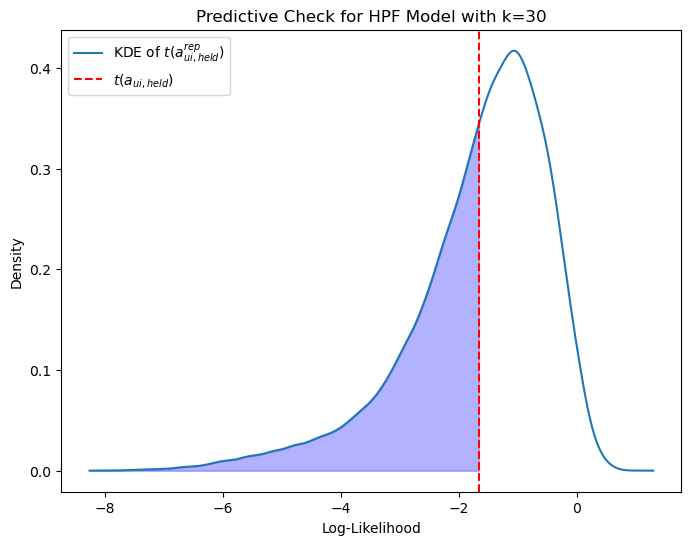

In [19]:
# Plotting the kernel density estimate (KDE)
predictive_score = np.mean(predictive_scores)
logging.info(f"Predictive Score for k={k}: {predictive_score}")

kde = gaussian_kde(replicated_log_probs)
x_vals = np.linspace(min(replicated_log_probs), max(replicated_log_probs), 1000)
kde_vals = kde(x_vals)

plt.figure(figsize=(8, 6))
plt.plot(x_vals, kde_vals, label='KDE of $t(a^{rep}_{ui,held})$')
plt.axvline(x=np.mean(actual_log_probs), color='r', linestyle='--', label='$t(a_{ui,held})$')
plt.fill_between(x_vals, kde_vals, where=(x_vals <= np.mean(actual_log_probs)), color='blue', alpha=0.3)
plt.title(f'Predictive Check for HPF Model with k={k}')
plt.xlabel('Log-Likelihood')
plt.ylabel('Density')
plt.legend()
plt.show()
